## Overview

XBeach needs wave boundary conditions at the offshore boundary. In rompy-xbeach,
you can specify these in **two ways**:

1. **Manual Specification** (`Config.wave_boundary`): Use when you have pre-existing
   boundary files or want simple parametric conditions

2. **Data-Driven Generation** (`Config.input.wave`): Automatically generate boundary
   files from data sources (model output, observations, etc.)

Both approaches use the same **wave boundary parameters** (`wbc`) to control how
XBeach processes the boundary conditions.

## Setup

In [1]:
from pathlib import Path
import xarray as xr
import warnings
warnings.filterwarnings("ignore")

from rompy.core.time import TimeRange
from rompy_xbeach.config import Config, DataInterface
from rompy_xbeach.grid import RegularGrid
from rompy_xbeach.data.base import XBeachBathy
from rompy_xbeach.source import SourceCRSFile, SourceCRSWavespectra

# Setup paths
HERE = Path("/source/csiro/rompy-xbeach/tests")
DATA_DIR = HERE / "data"
OUT_DIR = Path("wave-boundary-tutorial")
OUT_DIR.mkdir(exist_ok=True, parents=True)

print(f"Data directory: {DATA_DIR}")
print(f"Output directory: {OUT_DIR}")

Data directory: /source/csiro/rompy-xbeach/tests/data
Output directory: wave-boundary-tutorial


## Common Setup

Define grid, time ranges, and data sources we'll use throughout.

In [2]:
# Model grid
grid = RegularGrid(
    ori=dict(x=115.594239, y=-32.641104, crs="epsg:4326"),
    alfa=347.0,
    dx=10,
    dy=15,
    nx=230,
    ny=220,
    crs="28350",
)

# Data sources
source_spectra = SourceCRSWavespectra(
    uri=DATA_DIR / "aus-20230101.nc",
    reader="read_ww3",
)

source_param = SourceCRSFile(
    uri=DATA_DIR / "smc-params-20230101.nc",
    crs=4326,
    x_dim="lon",
    y_dim="lat",
)

# Time ranges
times_spectra = TimeRange(start="2023-01-01T00", end="2023-01-01T12", interval="1h")
times_param = TimeRange(start="2023-01-01T00", end="2023-01-01T03", interval="1h")

print(f"Grid: {grid.nx}x{grid.ny} cells")
print(f"Spectral data: {source_spectra.uri.name}")
print(f"Parameter data: {source_param.uri.name}")

Grid: 230x220 cells
Spectral data: aus-20230101.nc
Parameter data: smc-params-20230101.nc


# Part 1: Manual Specification (`Config.wave_boundary`)

Use this approach when you have pre-existing boundary files or want simple
parametric wave conditions.

## Example 1.1: Spectral Boundary with Pre-existing File

The most common case - you have a JONSWAP file from another source.

In [3]:
from rompy_xbeach.components.boundary.specification import SpectralWaveBoundary
from rompy_xbeach.components.boundary.parameters import SpectralWaveBoundaryConditions

# Create a spectral boundary pointing to your file
wave_boundary = SpectralWaveBoundary(
    wbctype="jons",
    bcfile="jonswap.txt",  # Your pre-existing file
    wbc=SpectralWaveBoundaryConditions(
        nmax=0.8,           # Ratio of max/mean frequency
        rt=3600.0,          # Duration of wave record (s)
        dtbc=1.0,           # Time step in boundary file (s)
    )
)

print("Spectral boundary created:")
print(f"  wbctype: {wave_boundary.wbctype}")
print(f"  bcfile: {wave_boundary.bcfile}")
print(f"  Parameters: {wave_boundary.wbc.model_dump(exclude_none=True)}")

Spectral boundary created:
  wbctype: jons
  bcfile: jonswap.txt
  Parameters: {'nmax': 0.8, 'rt': 3600.0, 'dtbc': 1.0}


## Example 1.2: Stationary Waves (No File Needed)

For simple parametric waves - no file required!

In [4]:
from rompy_xbeach.components.boundary.specification import NonSpectralWaveBoundary
from rompy_xbeach.components.boundary.parameters import NonSpectralWaveBoundaryConditions

# Simple stationary waves
wave_boundary = NonSpectralWaveBoundary(
    wbctype="stat",
    wbc=NonSpectralWaveBoundaryConditions(
        Hrms=2.0,    # Wave height (m)
        Trep=12.0,   # Period (s)
        dir0=285.0,  # Direction (degrees from North)
        m=10,        # Directional spreading coefficient
    )
)

print("\nStationary wave boundary:")
print(f"  Hrms={wave_boundary.wbc.Hrms}m, Trep={wave_boundary.wbc.Trep}s")
print(f"  Direction={wave_boundary.wbc.dir0}°")


Stationary wave boundary:
  Hrms=2.0m, Trep=12.0s
  Direction=285.0°


## Example 1.3: No Wave Forcing

In [5]:
from rompy_xbeach.components.boundary.specification import OffWaveBoundary

# For tide-only or current-only simulations
wave_boundary = OffWaveBoundary()
print(f"\nNo wave forcing: wbctype={wave_boundary.wbctype}")


No wave forcing: wbctype=off


## Wave Boundary Parameters (wbc)

Both spectral and non-spectral boundaries can use additional parameters to control
how XBeach processes the boundary conditions.

In [6]:
# Spectral boundary with more parameters
wave_boundary = SpectralWaveBoundary(
    wbctype="jons",
    bcfile="jonswap.txt",
    wbc=SpectralWaveBoundaryConditions(
        # Time parameters
        rt=3600.0,
        dtbc=1.0,
        
        # Frequency/direction
        nmax=0.8,
        fcutoff=0.0,
        
        # Advanced options
        wbcevarreduce=1.0,      # Variance reduction factor
        bclwonly=False,         # Use only long waves
        wbcRemoveStokes=True,   # Remove Stokes drift
        wbcScaleEnergy=True,    # Scale energy to match Hm0
        random=True,            # Random seed
        correcthm0=True,        # Correct Hm0
    )
)

print("\nSpectral boundary with full parameters:")
for key, value in wave_boundary.wbc.model_dump(exclude_none=True).items():
    print(f"  {key}: {value}")


Spectral boundary with full parameters:
  nmax: 0.8
  wbcevarreduce: 1.0
  bclwonly: 0
  wbcRemoveStokes: 1
  wbcScaleEnergy: 1
  rt: 3600.0
  dtbc: 1.0
  correcthm0: 1
  fcutoff: 0.0
  random: 1


## Using in Config

Here's how to use manual boundaries in a complete configuration.

In [7]:
import tempfile

# Create bathymetry
bathy = XBeachBathy(
    source={
        "model_type": "geotiff",
        "filename": str(DATA_DIR / "bathy.tif")
    }
)

# Create config with manual boundary
config = Config(
    grid=grid,
    bathy=bathy,
    wave_boundary=wave_boundary,  # Manual specification
)

# Simulate model generation to see parameters
class FakeRuntime:
    def __init__(self):
        self.period = TimeRange(start="2023-01-01T00", end="2023-01-01T12")
        self.staging_dir = Path(tempfile.mkdtemp())

runtime = FakeRuntime()
params = config(runtime)

# Show wave parameters
print("\nWave parameters in params.txt:")
print("=" * 60)
for key in ['wbctype', 'bcfile', 'nmax', 'rt', 'dtbc', 'wbcevarreduce']:
    if key in params:
        print(f"{key} = {params[key]}")
print("=" * 60)

2025-11-25 00:28:15 [INFO] rompy_xbeach.config : Using manual wave_boundary specification



Wave parameters in params.txt:
wbctype = jons
bcfile = jonswap.txt
nmax = 0.8
rt = 3600.0
dtbc = 1.0
wbcevarreduce = 1.0


# Part 2: Data-Driven Generation (`Config.input.wave`)

Generate boundary files automatically from data sources. This is the most common
approach when you have model output or observations.

## Understanding the Interface

Data boundary classes follow this naming pattern:

`Boundary{DataStructure}{DataType}{Bctype}`

- **DataStructure**: `Station`, `Grid`, or `Point`
- **DataType**: `Spectra` or `Param` (integrated parameters)
- **Bctype**: `Jons`, `Jonstable`, `Swan`, etc.

All boundary objects have a `get()` method that:
1. Extracts data at the offshore boundary location
2. Slices data over the model time period
3. Generates XBeach boundary files
4. Returns a `WaveBoundary` object

## JONS Boundary Type

JONSWAP spectrum - the most common spectral boundary type.

### From Station Spectra Data

Generate JONSWAP from full 2D wave spectra.

In [8]:
from rompy_xbeach.data.boundary import BoundaryStationSpectraJons

# Multiple bcfiles (one per time step) - DEFAULT
destdir = OUT_DIR / "jons_spectra_multi"
destdir.mkdir(exist_ok=True)


wbdata = BoundaryStationSpectraJons(
    source=source_spectra,
    filelist=True, # this is the default value
    coords=dict(x="lon", y="lat", s="site"), # this is the default value
    dtbc=2.0, # timestep of the generated wave timeseries, ignore it to let xbeach decide
    fnyq=0.3, # Nyquist frequency, ignore it to let xbeach decide
    dfj=None, # step size frequency for the Jonswap spectrum, ignore it to let xbeach decide
)

wbc = wbdata.get(destdir=destdir, grid=grid, time=times_spectra)
wbc.params

{'wbctype': 'jons', 'bcfile': 'jons-filelist.txt'}

In [9]:
# The jons-filelist.txt is created in the destdir directory and contains the list of
# bcfiles which are also created in the same workspace. One file is created for each
# time step in the input source data within the time period specified in the time
# parameter (the initial and end times are interpolated at time.start and time.end if
# these exact times are not present in the source dataset).

list(destdir.glob("*.txt"))

[PosixPath('wave-boundary-tutorial/jons_spectra_multi/jons-20230101T000000.txt'),
 PosixPath('wave-boundary-tutorial/jons_spectra_multi/jons-20230101T060000.txt'),
 PosixPath('wave-boundary-tutorial/jons_spectra_multi/jons-filelist.txt')]

In [10]:
# Let's inspect the content of bcfile. Note the duration is defined by the
# time steps in the source dataset which in this test data file is 6h.

filelist = destdir / wbc.params["bcfile"]
print(filelist.read_text())

FILELIST
21600 1 jons-20230101T000000.txt
21600 1 jons-20230101T060000.txt



In [11]:
# And the content of one of the bcfiles

bcfile = destdir / filelist.read_text().split("\n")[1].split()[-1]
print(bcfile.read_text())

mainang = 44.6871
gammajsp = 2.37594
fnyq = 0.3
s = 66.9335
Tp = 14.3738
Hm0 = 0.451453



#### Single bcfile

If the `filelist` parameter is set to `False`, a single `bcfile` is created at `time.start`
and used to run the entire simulation period.

In [12]:
destdir = OUT_DIR / "jons_spectra_single"
destdir.mkdir(exist_ok=True)


# Single bcfile at time.start
wbdata = BoundaryStationSpectraJons(
    source=source_spectra,
    filelist=False
)

# Generate the XBeach boundary file
wbc = wbdata.get(destdir=destdir, grid=grid, time=times_spectra)
wbc.params

{'wbctype': 'jons', 'bcfile': 'jons-20230101T000000.txt'}

In [13]:
# The filelist file is not created in the workspace, only one single bcfile

workspace_files = list(destdir.glob("*.txt"))
workspace_files

[PosixPath('wave-boundary-tutorial/jons_spectra_single/jons-20230101T000000.txt')]

In [14]:
print(workspace_files[0].read_text())

mainang = 44.6871
gammajsp = 2.37594
s = 66.9335
Tp = 14.3738
Hm0 = 0.451453



### BoundaryStationParamJons

XBeach jonswap type wave boundary from station parameters input data

In [15]:
from rompy_xbeach.data.boundary import BoundaryStationParamJons

#### Multiple bcfiles

In [16]:
# Destination directory
destdir = OUT_DIR / "param_jons_multi"
destdir.mkdir(exist_ok=True)

# Instantiate the boundary object
wbdata = BoundaryStationParamJons(
    source=source_param,
    coords=dict(s="seapoint", x="longitude", y="latitude", t="time"),
    hm0="phs1",
    tp="ptp1",
    mainang="pdp1",
    gammajsp="ppe1",
    dspr="pspr1",
)

# Generate the XBeach boundary files and return the list of bcfiles
wbc = wbdata.get(destdir=destdir, grid=grid, time=times_param)
wbc.params

{'wbctype': 'jons', 'bcfile': 'jons-filelist.txt'}

In [17]:
sorted(destdir.glob("*.txt"))

[PosixPath('wave-boundary-tutorial/param_jons_multi/jons-20230101T000000.txt'),
 PosixPath('wave-boundary-tutorial/param_jons_multi/jons-20230101T010000.txt'),
 PosixPath('wave-boundary-tutorial/param_jons_multi/jons-20230101T020000.txt'),
 PosixPath('wave-boundary-tutorial/param_jons_multi/jons-filelist.txt')]

In [18]:
filelist = destdir / wbc.params["bcfile"]
print(filelist.read_text())

FILELIST
3600 1 jons-20230101T000000.txt
3600 1 jons-20230101T010000.txt
3600 1 jons-20230101T020000.txt



#### Single bcfile

In [19]:
# Destination directory
destdir = OUT_DIR / "param_jons_single"
destdir.mkdir(exist_ok=True)

wbdata = BoundaryStationParamJons(
    filelist=False,
    source=source_param,
    coords=dict(s="seapoint"), # all other coordinates are equal to the default values
    hm0="phs1",
    tp="ptp1",
    mainang="pdp1",
    gammajsp="ppe1",
    dspr="pspr1",
)

# Generate the XBeach boundary files and return the list of bcfiles
wbc = wbdata.get(destdir=destdir, grid=grid, time=times_param)
wbc.params

{'wbctype': 'jons', 'bcfile': 'jons-20230101T000000.txt'}

In [20]:
workspace_files = list(destdir.glob("*.txt"))
workspace_files

[PosixPath('wave-boundary-tutorial/param_jons_single/jons-20230101T000000.txt')]

In [21]:
print(workspace_files[0].read_text())

mainang = 254.158
gammajsp = 2.68225
s = 21.9514
Tp = 13.1659
Hm0 = 0.875435



In [22]:
wbdata = BoundaryStationParamJons(
    filelist=False,
    source=source_param,
    coords=dict(s="seapoint"),
    hm0="phs1",
    tp="ptp1",
    mainang="pdp1",
)

bcfile = wbdata.get(destdir=destdir, grid=grid, time=times_param)

print(workspace_files[0].read_text())

mainang = 254.158
Tp = 13.1659
Hm0 = 0.875435



Alternatively, it is possible to define any of the jonswap parameters as a float value,
in which case that float is used to define the jonswap parameter in the bcfiles

In [23]:
wbdata = BoundaryStationParamJons(
    filelist=False,
    source=source_param,
    coords=dict(s="seapoint"),
    hm0="phs1",
    tp="ptp1",
    mainang="pdp1",
    dspr=20.0,
    gammajsp=3.0,
)

wbc = wbdata.get(destdir=destdir, grid=grid, time=times_param)

print(workspace_files[0].read_text())

mainang = 254.158
gammajsp = 3
s = 15.414
Tp = 13.1659
Hm0 = 0.875435



Notice `BoundaryStationParamJons` takes the directional wave spreading `dspr` as input,
in degrees, which is the parameter usually available from spectral wave models - the
Jonswap spreading coefficient `s` is calculated from that parameter

## jonstable bctype

### BoundaryStationSpectraJonstable

XBeach jonswap table type wave boundary from station spectra input data

In [24]:
from rompy_xbeach.data.boundary import BoundaryStationSpectraJonstable

In [25]:
destdir = OUT_DIR / "jonstable_spectra"
destdir.mkdir(exist_ok=True)

# Instantiate the boundary object
wbdata = BoundaryStationSpectraJonstable(
    source=source_spectra,
)

# Generate the XBeach boundary file
wbc = wbdata.get(destdir=destdir, grid=grid, time=times_spectra)
wbc.params

{'wbctype': 'jonstable',
 'bcfile': 'jonstable-20230101T000000-20230101T120000.txt'}

In [26]:
filename = destdir / wbc.params["bcfile"]
print(filename.read_text())

0.451453 14.3738 44.6871 2.37594 66.9335 21600 1
0.472394 14.4435 44.6857 2.45055 90.0861 21600 1
0.490301 14.2813 44.7835 2.38401 48.2725 21600 1



### BoundaryStationParamJonstable

XBeach jonswap table type wave boundary from station parameters input data

In [27]:
from rompy_xbeach.data.boundary import BoundaryStationParamJonstable

In [28]:
destdir = OUT_DIR / "jonstable_param"
destdir.mkdir(exist_ok=True)

# Instantiate the boundary object
wbdata = BoundaryStationParamJonstable(
    source=source_param,
    coords=dict(s="seapoint"),
    hm0="phs1",
    tp="ptp1",
    mainang="pdp1",
    gammajsp="ppe1",
    dspr="pspr1",
)

# Generate the XBeach boundary files and return the list of bcfiles
wbc = wbdata.get(destdir=destdir, grid=grid, time=times_param)
wbc.params

{'wbctype': 'jonstable',
 'bcfile': 'jonstable-20230101T000000-20230101T030000.txt'}

In [29]:
filename = destdir / wbc.params["bcfile"]
print(filename.read_text())

0.875435 13.1659 254.158 2.68225 21.9514 3600 1
0.909496 13.1292 254.18 2.71106 22.1417 3600 1
0.802303 14.8497 258.658 3.33514 37.515 3600 1
0.869525 14.4893 258.572 3.04059 32.5684 3600 1



## SWAN bctype

### BoundaryStationSpectraSwan

XBeach SWAN 2D spectra type wave boundary from station spectra input data

In [30]:
from wavespectra import read_swan

from rompy_xbeach.data.boundary import BoundaryStationSpectraSwan

#### Single bcfile

In [31]:
destdir = OUT_DIR / "swan_spectra_single"
destdir.mkdir(exist_ok=True)

# Instantiate the boundary object
wbdata = BoundaryStationSpectraSwan(
    source=source_spectra,
    filelist=False
)

# Generate the XBeach boundary file
wbc = wbdata.get(destdir=destdir, grid=grid, time=times_spectra)
wbc.params

{'wbctype': 'swan', 'bcfile': 'swan-20230101T000000.txt'}

In [32]:
filename = destdir / wbc.params["bcfile"]
dset = read_swan(filename)
dset

<xarray.Dataset> Size: 880B
Dimensions:  (time: 1, lat: 1, lon: 1, freq: 11, dir: 8)
Coordinates:
  * time     (time) datetime64[ns] 8B 2025-11-25T00:28:00
  * lat      (lat) float64 8B -32.63
  * lon      (lon) float64 8B 115.6
  * freq     (freq) float64 88B 0.05417 0.05959 0.06555 ... 0.1161 0.1277 0.1405
  * dir      (dir) float64 64B 0.0 45.0 90.0 135.0 180.0 225.0 270.0 315.0
Data variables:
    efth     (time, lat, lon, freq, dir) float64 704B 0.0001201 ... 1.863e-05

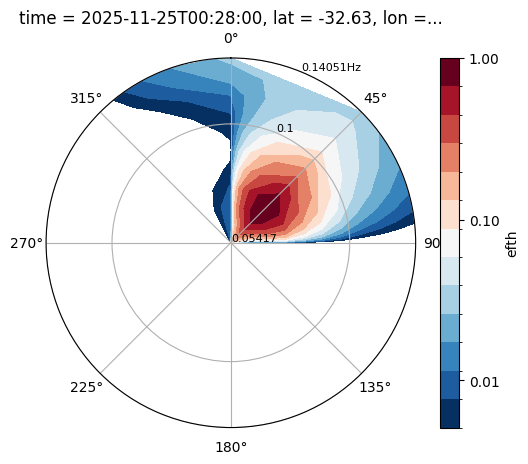

In [33]:
dset.squeeze().spec.plot()

#### Multiple bcfiles

In [34]:
destdir = OUT_DIR / "swan_spectra_multi"
destdir.mkdir(exist_ok=True)

# Instantiate the boundary object
wbdata = BoundaryStationSpectraSwan(
    source=source_spectra,
)

# Generate the XBeach boundary file
wbc = wbdata.get(destdir=destdir, grid=grid, time=times_spectra)
wbc.params

{'wbctype': 'swan', 'bcfile': 'swan-filelist.txt'}

In [35]:
sorted(destdir.glob("*.txt"))

[PosixPath('wave-boundary-tutorial/swan_spectra_multi/swan-20230101T000000.txt'),
 PosixPath('wave-boundary-tutorial/swan_spectra_multi/swan-20230101T060000.txt'),
 PosixPath('wave-boundary-tutorial/swan_spectra_multi/swan-filelist.txt')]

In [36]:
filelist = destdir / wbc.params["bcfile"]
print(filelist.read_text())

FILELIST
21600 1 swan-20230101T000000.txt
21600 1 swan-20230101T060000.txt



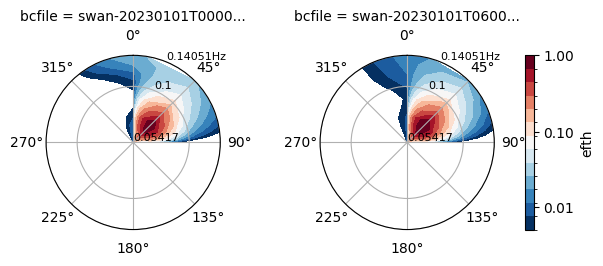

In [37]:
bcfiles = [row.split()[-1] for row in filelist.read_text().split("\n")[1:-1]]
dset = xr.concat([read_swan(destdir / f).squeeze() for f in bcfiles], dim="bcfile")
dset["bcfile"] = bcfiles
dset.spec.plot(col="bcfile")

### Using Wave Boundary Parameters with Data

**Key point**: You can specify `wbc` parameters with data-driven boundaries too!

In [38]:
destdir = OUT_DIR / "jons_param_with_wbc"
destdir.mkdir(exist_ok=True)

wb_data = BoundaryStationParamJons(
    filelist=False,
    source=source_param,
    coords=dict(s="seapoint"),
    hm0="phs1",
    tp="ptp1",
    mainang="pdp1",
    # Specify wave boundary parameters
    wbc=SpectralWaveBoundaryConditions(
        nmax=0.8,
        rt=3600.0,
        dtbc=1.0,
        wbcevarreduce=1.0,
        bclwonly=False,
        wbcRemoveStokes=True,
    )
)

wbc = wb_data.get(destdir=destdir, grid=grid, time=times_param)

print("\nJONS with wbc parameters:")
print(f"  bcfile: {wbc.bcfile}")
print(f"\nWBC parameters used:")
for key, value in wbc.wbc.model_dump(exclude_none=True).items():
    print(f"  {key}: {value}")


JONS with wbc parameters:
  bcfile: jons-20230101T000000.txt

WBC parameters used:
  nmax: 0.8
  wbcevarreduce: 1.0
  bclwonly: 0
  wbcRemoveStokes: 1
  rt: 3600.0
  dtbc: 1.0


## Using in Config

Here's how to use data-driven boundaries in a complete configuration.

In [39]:
# Create config with data-driven boundary
wb_data = BoundaryStationParamJons(
    source=source_param,
    coords=dict(s="seapoint"),
    hm0="phs1",
    tp="ptp1",
    mainang="pdp1",
    gammajsp="ppe1",
    dspr="pspr1",
    wbc=SpectralWaveBoundaryConditions(
        nmax=0.8,
        rt=3600.0,
        dtbc=1.0,
    )
)

config = Config(
    grid=grid,
    bathy=bathy,
    input=DataInterface(wave=wb_data),  # Data-driven generation
)

print("\nData-driven config created:")
print(f"  Grid: {config.grid.nx}x{config.grid.ny}")
print(f"  Wave data: {config.input.wave.id}")
print(f"  Source: {config.input.wave.source.uri.name}")


Data-driven config created:
  Grid: 230x220
  Wave data: jons
  Source: smc-params-20230101.nc


# Summary

## Two Approaches

1. **Manual Specification** (`Config.wave_boundary`):
   - Use `SpectralWaveBoundary`, `NonSpectralWaveBoundary`, etc.
   - For pre-existing files or simple parametric conditions

2. **Data-Driven Generation** (`Config.input.wave`):
   - Use `BoundaryStation*`, `BoundaryGrid*`, etc.
   - Automatically generate files from data sources

## Wave Boundary Parameters (`wbc`)

**Both approaches** can use the same wave boundary parameters:
- `SpectralWaveBoundaryConditions` for spectral boundaries
- `NonSpectralWaveBoundaryConditions` for non-spectral boundaries

These control how XBeach processes the boundary conditions (time steps, 
frequency range, energy scaling, Stokes drift, etc.).

## Key Points

- **Cannot mix**: Use either `wave_boundary` OR `input.wave`, not both
- **File options**: `filelist=True` (multiple files) or `False` (single file)
- **Data flexibility**: Mix data variables with constant values
- **Same parameters**: `wbc` works the same way in both approaches